In [2]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding,Dropout, SpatialDropout1D
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer


In [3]:
data = pd.read_csv(r"C:\Users\G VARSHIT HARIPRASAD\Desktop\Intenship DSML\Reviews.csv\Reviews.csv")

In [4]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [5]:
data.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,568454.000000,568454.000000,568454.00000,568454.000000,5.684540e+05
mean,284227.500000,1.743817,2.22881,4.183199,1.296257e+09
std,164098.679298,7.636513,8.28974,1.310436,4.804331e+07
min,1.000000,0.000000,0.00000,1.000000,9.393408e+08
25%,142114.250000,0.000000,0.00000,4.000000,1.271290e+09
50%,284227.500000,0.000000,1.00000,5.000000,1.311120e+09
75%,426340.750000,2.000000,2.00000,5.000000,1.332720e+09
max,568454.000000,866.000000,923.00000,5.000000,1.351210e+09


In [4]:
data['sentiment'] = data['Score'].apply(lambda x: 1 if x > 3 else 0)
data['review'] = data['Text']

In [5]:
def preprocess_text(text):
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    text = re.sub(r'\W', ' ', text)  # Remove special characters
    text = text.lower()  # Convert to lowercase
    return text

In [6]:
data['cleaned_review'] = data['review'].apply(preprocess_text)

In [7]:
sampled_data = data.sample(n=50000, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(sampled_data['cleaned_review'], sampled_data['sentiment'], test_size=0.2, random_state=42)


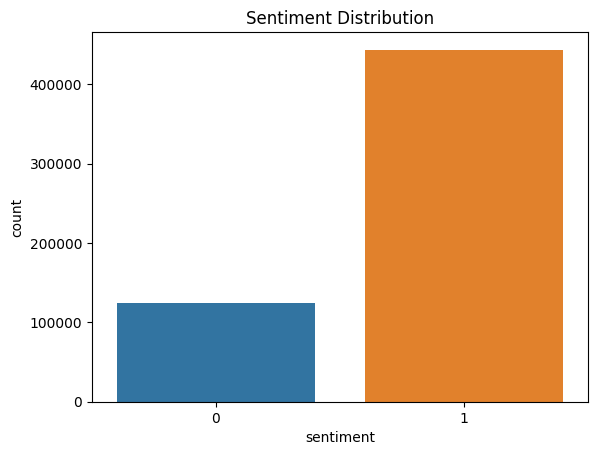

In [8]:
sns.countplot(x='sentiment', data=data)
plt.title('Sentiment Distribution')
plt.show()

In [9]:
positive_reviews = ' '.join(data[data['sentiment'] == 1]['cleaned_review'])
negative_reviews = ' '.join(data[data['sentiment'] == 0]['cleaned_review'])

In [10]:
!pip install wordcloud

In [11]:
wordcloud_positive = WordCloud(width=800, height=400, max_font_size=100, background_color='white').generate(positive_reviews)
wordcloud_negative = WordCloud(width=800, height=400, max_font_size=100, background_color='white').generate(negative_reviews)


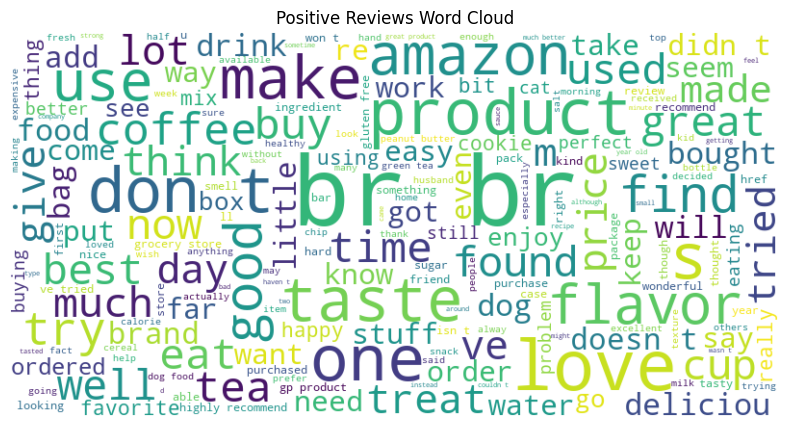

In [12]:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Positive Reviews Word Cloud')
plt.axis('off')
plt.show()

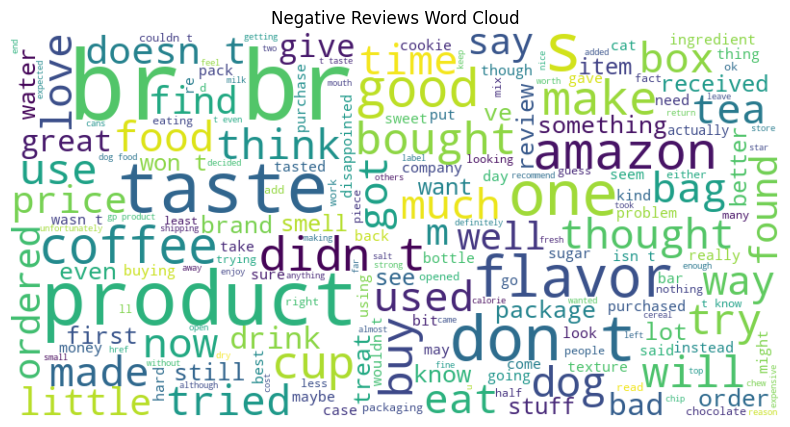

In [13]:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Negative Reviews Word Cloud')
plt.axis('off')
plt.show()

In [14]:
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train).toarray()
X_test_tfidf = vectorizer.transform(X_test).toarray()

In [15]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(data['cleaned_review'])

In [16]:
X_train_tokens = tokenizer.texts_to_sequences(X_train)
X_test_tokens = tokenizer.texts_to_sequences(X_test)


In [17]:
max_sequence_length = 500
X_train_padded = pad_sequences(X_train_tokens, maxlen=max_sequence_length)
X_test_padded = pad_sequences(X_test_tokens, maxlen=max_sequence_length)


In [18]:
print("X_train_padded shape:", X_train_padded.shape)
print("X_test_padded shape:", X_test_padded.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print("First few labels:", y_train[:5])

X_train_padded shape: (40000, 500)
X_test_padded shape: (10000, 500)
y_train shape: (40000,)
y_test shape: (10000,)
First few labels: 383933    0
175004    1
408618    0
177163    1
505056    1
Name: sentiment, dtype: int64


In [26]:
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=max_sequence_length))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

In [27]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 500, 128)          640000    
                                                                 
 spatial_dropout1d (Spatial  (None, 500, 128)          0         
 Dropout1D)                                                      
                                                                 
 lstm (LSTM)                 (None, 100)               91600     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 731701 (2.79 MB)
Trainable params: 731701 (2.79 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [28]:
history = model.fit(X_train_padded, y_train, epochs=5, batch_size=32, validation_data=(X_test_padded, y_test), verbose=2)

Epoch 1/5
1250/1250 - 479s - loss: 0.3467 - accuracy: 0.8519 - val_loss: 0.2836 - val_accuracy: 0.8830 - 479s/epoch - 383ms/step
Epoch 2/5
1250/1250 - 502s - loss: 0.2591 - accuracy: 0.8950 - val_loss: 0.2766 - val_accuracy: 0.8848 - 502s/epoch - 401ms/step
Epoch 3/5
1250/1250 - 6232s - loss: 0.2177 - accuracy: 0.9138 - val_loss: 0.2649 - val_accuracy: 0.8926 - 6232s/epoch - 5s/step
Epoch 4/5
1250/1250 - 495s - loss: 0.1860 - accuracy: 0.9275 - val_loss: 0.2923 - val_accuracy: 0.8944 - 495s/epoch - 396ms/step
Epoch 5/5
1250/1250 - 640s - loss: 0.1617 - accuracy: 0.9387 - val_loss: 0.2881 - val_accuracy: 0.8859 - 640s/epoch - 512ms/step


In [40]:
loss, accuracy = model.evaluate(X_test_padded, y_test, verbose=2)
print(f'Test Accuracy: {accuracy}')

313/313 - 36s - loss: 0.2881 - accuracy: 0.8859 - 36s/epoch - 114ms/step
Test Accuracy: 0.8859000205993652


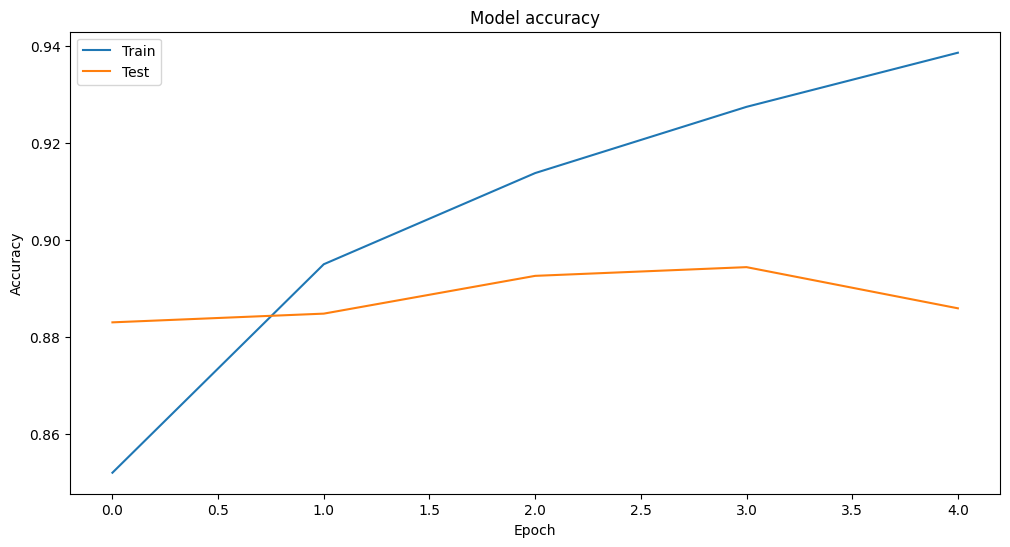

In [31]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

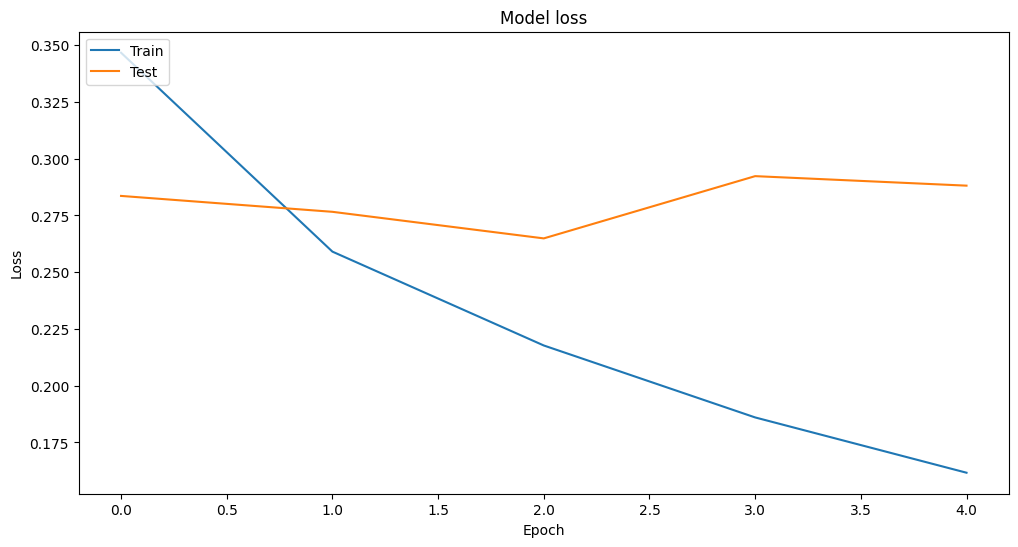

In [32]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [35]:
def predict_sentiment(review):
    review_cleaned = preprocess_text(review)
    review_tokenized = tokenizer.texts_to_sequences([review_cleaned])
    review_padded = pad_sequences(review_tokenized, maxlen=max_sequence_length)
    prediction = model.predict(review_padded)
    sentiment = 'Positive' if prediction[0][0] > 0.5 else 'Negative'
    return sentiment

In [36]:
example_reviews = [
    "This product is amazing! Highly recommend it.",
    "Terrible quality, I am very disappointed.",
    "It's okay, does the job but nothing special.",
    "Absolutely love it! Best purchase ever.",
    "Not worth the money, very poor performance."
]

In [37]:
for review in example_reviews:
    sentiment = predict_sentiment(review)
    print(f"Review: {review}")
    print(f"Predicted Sentiment: {sentiment}\n")

1/1 [==============================] - 0s 429ms/step
Review: This product is amazing! Highly recommend it.
Predicted Sentiment: Positive

1/1 [==============================] - 0s 78ms/step
Review: Terrible quality, I am very disappointed.
Predicted Sentiment: Negative

1/1 [==============================] - 0s 88ms/step
Review: It's okay, does the job but nothing special.
Predicted Sentiment: Negative

1/1 [==============================] - 0s 137ms/step
Review: Absolutely love it! Best purchase ever.
Predicted Sentiment: Positive

1/1 [==============================] - 0s 143ms/step
Review: Not worth the money, very poor performance.
Predicted Sentiment: Negative



In [45]:
new_review = "Satisfactory"
print(predict_sentiment(new_review))

1/1 [==============================] - 0s 75ms/step
Positive


In [46]:
new_review = "Bad product"
print(predict_sentiment(new_review))

1/1 [==============================] - 0s 67ms/step
Negative
